In [1]:
import stormpy 
from mce_irl_pomdps import parser_pomdp
from mce_irl_pomdps import irl_pomdp_solver as irl_solver
import numpy as np

In [2]:
# stormpy.pomdp.PomdpMemoryPattern.selective_counter
# stormpy.pomdp.PomdpMemoryPattern.fixed_counter
# stormpy.pomdp.PomdpMemoryPattern.selective_ring
# stormpy.pomdp.PomdpMemoryPattern.fixed_ring
# stormpy.pomdp.PomdpMemoryPattern.full
# stormpy.pomdp.PomdpMemoryPattern.trivial
np.random.seed(201)
# The optimal demonstration is coming from a 1-FSC
pomdp_r_1 = parser_pomdp.PrismModel("rocksample_4_4_2.prism",
                                    counter_type=stormpy.pomdp.PomdpMemoryPattern.fixed_counter, 
                                    memory_len=1, export=True)
# True reward in the POMDP environment
weight = {'total_time' : 1, 'finish_grock' : 50, 'sense_time' : 2}

In [6]:
print(pomdp_r_1.pomdp)

-------------------------------------------------------------- 
Model type: 	POMDP (sparse)
States: 	371
Transitions: 	3056
Choices: 	1905
Observations: 	48
Reward Models:  total_time, finish_grock, sense_time
State Labels: 	5 labels
   * init -> 1 item(s)
   * deadlock -> 0 item(s)
   * memstate_0 -> 371 item(s)
   * notr1done -> 282 item(s)
   * r2done -> 92 item(s)
Choice Labels: 	none
-------------------------------------------------------------- 



In [36]:
# Build the instance without side information
# Options for the solver
options_opt = irl_solver.OptOptions(mu=1e1, mu_spec=1e4, maxiter=200, maxiter_weight=50,
                      graph_epsilon=1e-6, discount=0.999, verbose=True, verbose_solver=False)
irlPb_1 = irl_solver.IRLSolver(pomdp_r_1, init_trust_region=1.1, max_trust_region=1.5, options=options_opt)
pol_val_grb_1mem = irlPb_1.from_reward_to_policy_via_scp(weight)

Initialize Linear subproblem to be solved at iteration k
[Time used to build the full Model : 0.14806866645812988]
[Initialization] Reward attained -33.03511291032705, Spec SAT : 0
[Initialization] Number of steps : 0
[Iter 0]: Reward attained -19.731654035632186, Spec SAT : 0, Trust region : 1.1500000000000001
[Iter 0]: Update time : 0.017900705337524414s, Checking time : 0.01055765151977539s, Solve time: 0.768742561340332s
[Iter 1]: Reward attained -6.983262621268553, Spec SAT : 0, Trust region : 1.225
[Iter 1]: Update time : 0.03431057929992676s, Checking time : 0.02203226089477539s, Solve time: 0.8986301422119141s
[Iter 2]: Reward attained 3.4696088983231266, Spec SAT : 0, Trust region : 1.3375000000000001
[Iter 2]: Update time : 0.05185341835021973s, Checking time : 0.03272128105163574s, Solve time: 1.2046823501586914s
[Iter 3]: Reward attained 11.529118101928626, Spec SAT : 0, Trust region : 1.5
[Iter 3]: Update time : 0.06827688217163086s, Checking time : 0.044812917709350586s, 

In [5]:
pol_val_mdp = irlPb_1.from_reward_to_optimal_policy_mdp_lp(weight, gamma=options_opt.discount)

Initialize Linear subproblem to be solved at iteration k
[Time used to build the full Model : 0.07326054573059082]
[Total solving time : 0.0284574031829834]
[Optimal expected reward : 13.810187086563753]


In [7]:
# Get a trajectory from the pomdp policy and the mdp policy
traj_pomdp_1, _ = pomdp_r_1.simulate_policy(pol_val_grb_1mem, weight, 20, 200,
                                            obs_based=True, stop_at_accepting_state=True)
traj_mdp, _ = pomdp_r_1.simulate_policy(pol_val_mdp, weight, 20, 200,
                                            obs_based=False, stop_at_accepting_state=True)

In [8]:
features_traj_pomdp_1 = irlPb_1.compute_feature_from_trajectory(traj_pomdp_1)
features_traj_mdp = irlPb_1.compute_feature_from_trajectory(traj_mdp)
print('Feature POMDP: \n', features_traj_pomdp_1)
print('Feature MDP: \n', features_traj_mdp)

Feature POMDP: 
 {'total_time': -2.444654947101001, 'finish_grock': 0.5476044953028989, 'sense_time': -0.49900069980000006}
Feature MDP: 
 {'total_time': -3.141560741603653, 'finish_grock': 0.9951603874090463, 'sense_time': -1.3961036987001}


In [9]:
# Set some parameters for trust region
# Define some parameters when optimizing the problems
# Set the parameter for the trust region
irl_solver.trustRegion = {'red' : lambda x : ((x - 1) / 1.5 + 1),
                          'aug' : lambda x : min(1.5,(x-1)*1.5+1),
                          'lim' : 1+1e-6}
# Set the parameter for minimum state visitation count to be considered as zero
irl_solver.ZERO_NU_S = 1e-8
irl_solver.gradientStepSize = lambda iterVal, diffFeat : 1.0 /np.power(iterVal+1, 0.5)

In [10]:
# Learn on a FSC of memory 4
pomdp_r_4 = parser_pomdp.PrismModel("rocksample_4_4_2.prism",
                                    counter_type=stormpy.pomdp.PomdpMemoryPattern.fixed_counter, 
                                    memory_len=5, export=False)
# Options for the solver
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e4, maxiter=200, max_update=3, maxiter_weight=200, rho_weight=1,
                      graph_epsilon=1e-6, discount=0.999, verbose=False, verbose_solver=False, verbose_weight=True)

# First without side information
irlpb_r_4_nosi = irl_solver.IRLSolver(pomdp_r_4, init_trust_region=1.1, max_trust_region=1.5, options=options_opt)
weight_pomdp_4_nosi, pol_pomdp_4_nosi = irlpb_r_4_nosi.solve_irl_pomdp_given_traj(features_traj_pomdp_1)

# Then learn a policy based on the learned weight
print('\n##################################\n##################################\n#############################\n')
pol_pomdp_4_nosi_lopt = irlpb_r_4_nosi.from_reward_to_policy_via_scp(weight_pomdp_4_nosi)

# # Solve the problem with side information
# pomdp_r_4._has_sideinfo = True
# weight_pomdp_4_si, pol_pomdp_4_si = irlpb_r_4_nosi.solve_irl_pomdp_given_traj(features_traj_pomdp_1)

[No Iter 2]: Entropy + spec 317.54367547473424, Reward -185.2861901255863, Spec SAT : 0, Trust region : 1.3375000000000001
---------------- Printing visitation iteration 0 ---------------- 
-127.13969274918834 -2.444654947101001 total_time | rmsprop:  1554.8852452463987
0.31798646542108905 0.5476044953028989 finish_grock | rmsprop:  0.005272443964680371
-58.46448384181976 -0.49900069980000006 sense_time | rmsprop:  335.9997235887776
[No Iter 2]: Entropy + spec 78.56117553378152, Reward -142.27941019430963, Spec SAT : 0, Trust region : 1.3375000000000001
[Diff with feature matching] : 182.8901389739889 ]
[New weight value] : {'total_time': 3.2360679774925996, 'finish_grock': 3.2360658569795797, 'sense_time': 3.236067977466515} ]
Update time : 0.3777008056640625s, Checking time : 0.1585686206817627s, Solve time: 3.7882628440856934s
---------------- Printing visitation iteration 1 ---------------- 
-31.73501089169756 -2.444654947101001 total_time | rmsprop:  1485.189215857875
0.3436600444

In [11]:
weight_mdp_4_nosi, pol_mdp_4_nosi = irlpb_r_4_nosi.solve_irl_pomdp_given_traj(features_traj_mdp)

# Then learn a policy based on the learned weight
print('\n##################################\n##################################\n#############################\n')
pol_mdp_4_nosi_lopt = irlpb_r_4_nosi.from_reward_to_policy_via_scp(weight_mdp_4_nosi)

[No Iter 2]: Entropy + spec 317.54367547473424, Reward -185.2861901255863, Spec SAT : 0, Trust region : 1.3375000000000001
---------------- Printing visitation iteration 0 ---------------- 
-127.13969274918834 -3.141560741603653 total_time | rmsprop:  1537.5536741370393
0.31798646542108905 0.9951603874090463 finish_grock | rmsprop:  0.04585645206205521
-58.46448384181976 -1.3961036987001 sense_time | rmsprop:  325.6800012159613
[No Iter 2]: Entropy + spec 78.56132248407782, Reward -142.27972330824826, Spec SAT : 0, Trust region : 1.3375000000000001
[Diff with feature matching] : 181.7436860726923 ]
[New weight value] : {'total_time': 3.2360679774925187, 'finish_grock': 3.236067733688122, 'sense_time': 3.2360679774654604} ]
Update time : 0.374021053314209s, Checking time : 33.71590614318848s, Solve time: 3.8627405166625977s
---------------- Printing visitation iteration 1 ---------------- 
-31.734550954966615 -3.141560741603653 total_time | rmsprop:  1465.5542156574825
0.343672346397929

In [12]:
# Generate a bunch of trajectories
# np.random.seed(101)
nb_run = 2000
max_iter_per_run = 300
_, rewDataMdp = pomdp_r_1.simulate_policy(pol_val_mdp, weight, nb_run, max_iter_per_run, 
                        obs_based=False, stop_at_accepting_state=False)
_, rewDataPomdp_1mem = pomdp_r_1.simulate_policy(pol_val_grb_1mem, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDataPomdp_4mem_nosi = pomdp_r_4.simulate_policy(pol_pomdp_4_nosi, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDataPomdp_4mem_nosil = pomdp_r_4.simulate_policy(pol_pomdp_4_nosi_lopt, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDatamdp_4mem_nosi = pomdp_r_4.simulate_policy(pol_mdp_4_nosi, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDatamdp_4mem_nosil = pomdp_r_4.simulate_policy(pol_mdp_4_nosi_lopt, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
# _, rewDataPomdp_4mem = pomdp_r_4.simulate_policy(pol_val_grb_4mem, weight, nb_run, max_iter_per_run, 
#                         obs_based=True, stop_at_accepting_state=False)
# _, rewDataPomdp_10mem = pomdp_r_6.simulate_policy(pol_val_grb_6mem, weight, nb_run, max_iter_per_run, 
#                         obs_based=True, stop_at_accepting_state=False)

In [15]:
# discountArray = np.array([options_opt.discount**i for i in range(max_iter_per_run)])
discountArray = np.array([1 for i in range(max_iter_per_run)])
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_pol(rewData, cData=-1, color='red', label=None, alpha=0.5, plot_std=False, linestyle='solid'):
    rewData = np.array(rewData) * discountArray
    arr_rewData = np.cumsum(rewData, axis=1)
    mean_rew = np.mean(arr_rewData, axis = 0)
    min_rew = np.min(arr_rewData, axis=0)
    max_rew = np.max(arr_rewData, axis=0)
    std_rew = np.std(arr_rewData, axis=0)
    axis_x = np.array([i for i in range(mean_rew.shape[0])])
#     print(mean_rew.shape, cData)
    plt.plot(axis_x[:cData], mean_rew[:cData], color=color, label=label, linestyle=linestyle)
    if plot_std:
        plt.fill_between(axis_x[:cData], np.maximum(min_rew,mean_rew-std_rew)[:cData], np.minimum(max_rew,mean_rew+std_rew)[:cData], color=color, alpha=alpha)

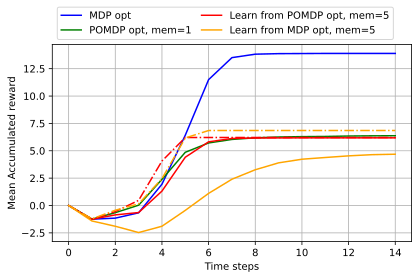

In [18]:
nData = 15
std_activate = False
plt.figure()

plot_pol(rewDataMdp, nData, color='blue', label='MDP opt', alpha=1, plot_std=std_activate)
plot_pol(rewDataPomdp_1mem, nData, color='green', label='POMDP opt, mem=1', alpha=0.8, plot_std=std_activate)
# plot_pol(pol_val_scp, color='red', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True)

plot_pol(rewDataPomdp_4mem_nosi, nData, color='red', label='Learn from POMDP opt, mem=5', alpha = 0.6, plot_std=std_activate)
# OPtimal policy with the learned weights
plot_pol(rewDataPomdp_4mem_nosil, nData, color='red', linestyle='dashdot', alpha = 0.6, plot_std=std_activate)

plot_pol(rewDatamdp_4mem_nosi, nData, color='orange', label='Learn from MDP opt, mem=5', alpha = 0.6, plot_std=std_activate)
# Optimal policy with the learned weughts from demo on the MDP
plot_pol(rewDatamdp_4mem_nosil, nData, color='orange', linestyle='dashdot', alpha = 0.6, plot_std=std_activate)

plt.ylabel('Mean Accumulated reward')
plt.xlabel('Time steps')
plt.grid(True)
plt.legend(ncol=2, bbox_to_anchor=(0,1), loc='lower left', columnspacing=1.0)
plt.tight_layout()
plt.show()

In [41]:
# Learn on a FSC of memory 4 -> Order between taking good quality rocks
pomdp_r_4_si = parser_pomdp.PrismModel("rocksample_4_4_2.prism", ["P=? [\"notr1done\" U \"r2done\"]", "P=? [F \"goal\"]"],
                                    counter_type=stormpy.pomdp.PomdpMemoryPattern.fixed_counter, 
                                    memory_len=5, export=True)
#  ["P=? [\"notr1done\" U \"r2done\"]"],

In [42]:
print(pomdp_r_4_si.pomdp)

-------------------------------------------------------------- 
Model type: 	POMDP (sparse)
States: 	742
Transitions: 	6109
Choices: 	4004
Observations: 	101
Reward Models:  total_time, finish_grock, sense_time
State Labels: 	10 labels
   * r2done -> 113 item(s)
   * notr1done -> 639 item(s)
   * deadlock -> 0 item(s)
   * init -> 1 item(s)
   * memstate_1 -> 48 item(s)
   * memstate_2 -> 143 item(s)
   * memstate_4 -> 331 item(s)
   * memstate_0 -> 1 item(s)
   * goal -> 28 item(s)
   * memstate_3 -> 219 item(s)
Choice Labels: 	none
-------------------------------------------------------------- 



In [43]:
# Build the instance without side information
# Options for the solver
irl_solver.trustRegion = {'red' : lambda x : ((x - 1) / 1.5 + 1),
                          'aug' : lambda x : min(2,(x-1)*1.5+1),
                          'lim' : 1+1e-6}
options_opt = irl_solver.OptOptions(mu=1e1, mu_spec=1e1, maxiter=1000, maxiter_weight=50,
                      graph_epsilon=1e-6, discount=0.999, verbose=True, verbose_solver=False)
irlPb_4_si = irl_solver.IRLSolver(pomdp_r_4_si, init_trust_region=2, max_trust_region=2, sat_thresh=0.95, options=options_opt)
pol_val_grb_4mem_si = irlPb_4_si.from_reward_to_policy_via_scp(weight)

Initialize Linear subproblem to be solved at iteration k
[Time used to build the full Model : 0.4376845359802246]
[Initialization] Reward attained -99.79807269752209, Spec SAT : 0.2552451806847053
[Initialization] Number of steps : 32.73760784314024
[Iter 0]: Reward attained -12.03393577573459, Spec SAT : 0.4688657846135349, Trust region : 2
[Iter 0]: Number of steps : 24.703332608038277
[Iter 0]: Update time : 0.0663595199584961s, Checking time : 0.03659653663635254s, Solve time: 3.04329252243042s
[Iter 1]: Reward attained -3.5098467100764186, Spec SAT : 0.6431352654468417, Trust region : 2
[Iter 1]: Number of steps : 22.793978194447266
[Iter 1]: Update time : 0.1271805763244629s, Checking time : 0.0703737735748291s, Solve time: 10.374154567718506s
[Iter 2]: Reward attained 2.5649332634941886, Spec SAT : 0.6670208569076151, Trust region : 2
[Iter 2]: Number of steps : 17.462104082442686
[Iter 2]: Update time : 0.23790931701660156s, Checking time : 0.1031043529510498s, Solve time: 15.3

In [23]:
pomdp_r_4_si._has_sideinfo = False
pol_val_mdp_si = irlPb_4_si.from_reward_to_optimal_policy_mdp_lp(weight, gamma=options_opt.discount)
pomdp_r_4_si._has_sideinfo = True

Initialize Linear subproblem to be solved at iteration k
[Time used to build the full Model : 0.15910577774047852]
[Total solving time : 0.043605804443359375]
[Optimal expected reward : 43.664725846971564]


In [ ]:
options_opt = irl_solver.OptOptions(mu=1e3, mu_spec=1e4, maxiter=100, max_update=4, maxiter_weight=200, rho_weight=1,
                      graph_epsilon=1e-6, discount=0.999, verbose=False, verbose_solver=False, verbose_weight=True)
pomdp_r_4._has_sideinfo = True
irlpb_r_4_nosi = irl_solver.IRLSolver(pomdp_r_4, init_trust_region=1.1, max_trust_region=1.5, sat_thresh=0.9, options=options_opt)
weight_pomdp_4_si, pol_pomdp_4_si = irlpb_r_4_nosi.solve_irl_pomdp_given_traj(features_traj_pomdp_1)

In [ ]:
# Generate a bunch of trajectories
# np.random.seed(101)
nb_run = 2000
max_iter_per_run = 300
_, rewDataMdp = pomdp_r_1.simulate_policy(pol_val_mdp, weight, nb_run, max_iter_per_run, 
                        obs_based=False, stop_at_accepting_state=False)
_, rewDataPomdp_1mem = pomdp_r_1.simulate_policy(pol_val_grb_1mem, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDataPomdp_4mem_nosi = pomdp_r_4.simulate_policy(pol_pomdp_4_nosi, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
_, rewDataPomdp_4mem_si = pomdp_r_4.simulate_policy(pol_pomdp_4_si, weight, nb_run, max_iter_per_run, 
                        obs_based=True, stop_at_accepting_state=False)
# _, rewDataPomdp_4mem = pomdp_r_4.simulate_policy(pol_val_grb_4mem, weight, nb_run, max_iter_per_run, 
#                         obs_based=True, stop_at_accepting_state=False)
# _, rewDataPomdp_10mem = pomdp_r_6.simulate_policy(pol_val_grb_6mem, weight, nb_run, max_iter_per_run, 
#                         obs_based=True, stop_at_accepting_state=False)

In [ ]:
traj, rewDataPomdp_4mem_si = pomdp_r_4.simulate_policy(pol_pomdp_4_si, weight, 100, 300, 
                        obs_based=True, stop_at_accepting_state=False)

In [ ]:
np.array(rewDataPomdp_4mem_nosi)[:10,:12]

In [ ]:
np.array(rewDataPomdp_4mem_si)[:20,:12]
lPos = list()
for rewVal in rewDataPomdp_4mem_si:
    has_50, pos  = False, 0
    for j, y in enumerate(rewVal):
        if y == 50:
            has_50, pos = True, j
            break
    assert has_50
    lPos.append(pos)
print(lPos)

In [ ]:
# discountArray = np.array([options_opt.discount**i for i in range(max_iter_per_run)])
discountArray = np.array([1 for i in range(max_iter_per_run)])

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_pol(rewData, cData=-1, color='red', label='dum', alpha=0.5, plot_std=False, linestyle='solid'):
    rewData = np.array(rewData) * discountArray
    arr_rewData = np.cumsum(rewData, axis=1)
    mean_rew = np.mean(arr_rewData, axis = 0)
    min_rew = np.min(arr_rewData, axis=0)
    max_rew = np.max(arr_rewData, axis=0)
    std_rew = np.std(arr_rewData, axis=0)
    axis_x = np.array([i for i in range(mean_rew.shape[0])])
#     print(mean_rew.shape, cData)
    plt.plot(axis_x[:cData], mean_rew[:cData], color=color, label=label, linestyle=linestyle)
    if plot_std:
        plt.fill_between(axis_x[:cData], np.maximum(min_rew,mean_rew-std_rew)[:cData], np.minimum(max_rew,mean_rew+std_rew)[:cData], color=color, alpha=alpha)

In [ ]:
nData = 50
std_activate = False
plt.figure()
plot_pol(rewDataMdp, nData, color='blue', label='MDP', alpha=1, plot_std=std_activate)
plot_pol(rewDataPomdp_1mem, nData, color='green', label='POMDP, mem=1', alpha=0.8, plot_std=std_activate)
# plot_pol(pol_val_scp, color='red', nb_run=nb_run, nb_iter_run=max_iter_per_run, is_obs=True)
plot_pol(rewDataPomdp_4mem_nosi, nData, color='red', label='POMDP, mem=4', alpha = 0.6, plot_std=std_activate)
plot_pol(rewDataPomdp_4mem_si, nData, color='orange', label='POMDP si, mem=4', alpha = 0.6, plot_std=std_activate)
# plot_pol(rewDataPomdp_10mem, nData, color='yellow', label='POMDP, mem=10', alpha=0.6, plot_std=std_activate)
# plot_pol(rewDataSideInfoLp, color='cyan', label='Learned policy with side information,0.7', alpha=0.2)
plt.ylabel('Mean Accumulated reward')
plt.xlabel('Time steps')
plt.grid(True)
plt.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left', columnspacing=1.0)
plt.tight_layout()
plt.show()

In [10]:
import stormpy
import stormpy.simulator
import re

def parse_state_repr(state_repr):
    return state_repr

def gen_traj(sigma, pomdp, max_run, max_iter_per_run, obs_based=True):
    rand_seed = np.random.randint(0, 10000)
    simulator = stormpy.simulator.create_simulator(pomdp.pomdp, seed=rand_seed)
    res_traj = list()
    for i in range(max_run):
        # Initialize the simulator
        obs, reward = simulator.restart()
        current_state = simulator._report_state()
        # Save the sequence of states
        seq_obs = []
        for j in range(max_iter_per_run):
            # Get the list of available actions
            actList = [a for a in simulator.available_actions()]
            # Add the observaion, action to the sequence
            if obs_based:
                # Pick an action in the set of random actions with probability given by the policy
                act = np.random.choice(np.array([a for a in sigma[obs]]),p=np.array([probA for a, probA in sigma[obs].items()]))
            else:
                # Pick an action in the set of random actions with probability given by the
                act = np.random.choice(np.array([a for a in sigma[current_state]]), p=np.array([probA for a, probA in sigma[current_state].items()]))
            # Update the state of the simulator
            obs, reward = simulator.step(actList[act])
            current_state = simulator._report_state()
            seq_obs.append(parse_state_repr(pomdp.string_repr_state(current_state)))
            # Check if reaching a looping state
            if simulator.is_done():
                break
        res_traj.append(seq_obs)
    return res_traj

In [38]:
res = gen_traj(pol_val_grb_1mem, pomdp_r_1, 5, 500, obs_based=True)

In [40]:
res[2]

['[started\t& !done\t& r1qual\t& !r1taken\t& !r1lastobs\t& !r2qual\t& !r2taken\t& !r2lastobs\t& x=1\t& y=3]',
 '[started\t& !done\t& r1qual\t& !r1taken\t& !r1lastobs\t& !r2qual\t& !r2taken\t& !r2lastobs\t& x=0\t& y=3]',
 '[started\t& !done\t& r1qual\t& !r1taken\t& !r1lastobs\t& !r2qual\t& !r2taken\t& !r2lastobs\t& x=1\t& y=3]',
 '[started\t& !done\t& r1qual\t& !r1taken\t& !r1lastobs\t& !r2qual\t& !r2taken\t& !r2lastobs\t& x=0\t& y=3]',
 '[started\t& !done\t& r1qual\t& !r1taken\t& !r1lastobs\t& !r2qual\t& !r2taken\t& !r2lastobs\t& x=0\t& y=3]',
 '[started\t& !done\t& r1qual\t& !r1taken\t& !r1lastobs\t& !r2qual\t& !r2taken\t& !r2lastobs\t& x=0\t& y=2]',
 '[started\t& !done\t& r1qual\t& !r1taken\t& !r1lastobs\t& !r2qual\t& !r2taken\t& !r2lastobs\t& x=0\t& y=2]',
 '[started\t& !done\t& r1qual\t& !r1taken\t& !r1lastobs\t& !r2qual\t& !r2taken\t& !r2lastobs\t& x=1\t& y=2]',
 '[started\t& !done\t& r1qual\t& r1taken\t& !r1lastobs\t& !r2qual\t& !r2taken\t& !r2lastobs\t& x=1\t& y=2]',
 '[started\